# Plotting the CMB

### Aliki Litsa (Student ID number: 11572418)
### Marnix Heikamp (Student ID number: 1805188)
### Stan Bovenschen (Student ID number: 10639578)

The following cells include a simple coding approach for the plotting of the CMB power spectrum. The first step towards our goal is to calculate the Hubble parameter at redshift z, and from that, the sound horizon and distance travelled by photons at recombination. We, then, proceed by adding all components of the Universe one by one to our approximation, and determining the corresponding changes on the CMB power spectrum. Finally, we use the simple two-fluid approach (arXiv:astro-ph/9406050v1) in order to include all components of the ΛCDM model.

In [1]:
from __future__ import division
import numpy as np
from scipy.integrate import odeint, quad
import pylab as plt
from scipy.special import spherical_jn
%matplotlib inline

## Preliminary calculations

In [2]:
H_0 = 217 * 10**(-20)  # s^-1
Om_m = 0.31
Om_b = 0.022
Om_c = 0.11
Om_l = 0.69
Om_r = 5.4 * 10**(-5)
c = 9.7 * 10**(-15)  # Mpc/s

The distance travelled by photons at the time of recombination is given by solving the integral:
$$
D_* = c\int_0^{1100} \frac{dz}{H(z)}
$$
with
$$
H(z)^2 = H_0^2 \left( (1+z)^3 \Omega_m + (1+z)^4 \Omega_r + \Omega_\Lambda \right)
$$
with $\Omega_m = 0.31$, $\Omega_r = 5.4\times 10^{-5}$, $\Omega_\Lambda = 0.69$ and $H_0 = 67.8\mathrm{\,km\,s^{-1}\,Mpc^{-1}}$

Also, the sound horizon at recombination is given by:
$$
s_* = c_s \int_{1100}^\infty {\frac{dz}{H(z)}}
$$

with $c_s=c/\sqrt3$ for a Universe only including photons.

In [3]:
def H(z):
    """Returns the Hubble parameter at a redshift z, in 1/s"""
    return np.sqrt(H_0**2 * ((1 + z)**3 * Om_m + (1 + z)**4 * Om_r + Om_l))

def dD_dz(z):
    return 1/H(z)

def D(z):
    """Returns the distance travelled by a photon at redshift z, in Mpc"""
    return c * quad(dD_dz, a = 0, b = z)[0] 

# Distance travelled by a photon at recombination
D_st = D(1100)

# The speed of sound in Mpc/s
c_s  = c/np.sqrt(3)

# Sound horizon at recombination in Mpc
s_st = c_s * quad(dD_dz, a = 1100, b = np.inf)[0]

print('The distance travelled by photons at the time of recombination is: ', D_st, ' Mpc')
print('The size of the sound horizon at recombination is: ', s_st, ' Mpc')

('The distance travelled by photons at the time of recombination is: ', 14051.914051774384, ' Mpc')
('The size of the sound horizon at recombination is: ', 182.65092391681651, ' Mpc')


## CMB formulas:

The spectrum of initial curvature perturbations is given by:

$$
\Delta_{\zeta}^2(k) = A_s\Bigg(\frac{k}{k_*}\Bigg)^{n_s-1}
$$

where $A_s \simeq 2.196\times 10^{-9}$, $k_*\simeq 0.05\;Mpc^{-1}$ and $n_s\simeq 0.96$

The transfer function is:

$$
T(k) = |\Theta (\eta_*, k)|^2
$$

and the CMB power spectrum is given by:

$$
C_l = \int dlnk\;j_l^2(k,D_*)\Delta_{\zeta}^2(k)T(k)
$$

where $j_l$ is the spherical bessel function.

## CMB of a scale-invariant power spectrum

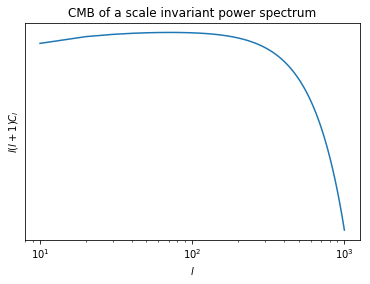

In [4]:
klist = np.logspace(np.log10(10**(-4)), np.log10(0.3), 2000)

def Delta_T_sq(k):
    return 1 

def dC_l_dk(k,l):
    return 4*np.pi * Delta_T_sq(k) * spherical_jn(l, k*D_st)**2 / k

def C_l(l):
    
    i = 10**(-4)
    step = (0.3 - 10**(-4))/1000
    result = 0
    
    while i <= 0.3:
        int_part = lambda l: quad(dC_l_dk, i, i + step, args=(l,))[0]
        result = result + int_part(l)
        i+=step
        
    return result


tab_cl = []

for l in range(10,1001, 10):
    tab_cl.append(C_l(l))
    
llist = np.linspace(10, 1001, 100)

def cl_interp(l):
    return np.interp(l, llist, tab_cl)

def pl_func(func, l):
    return l*(l+1)*func(l)

plt.loglog(llist, pl_func(cl_interp, llist))
plt.ylabel('$l(l+1)C_l$')
plt.xlabel('$l$')
plt.title('CMB of a scale invariant power spectrum')
plt.savefig('fig1.pdf')
plt.show()

## CMB of a Universe including only photons

In a Universe which only includes photons the solution to the temperature fluctuations is:

$$
\Theta (k, s)= \Theta _0 cos(ks)
$$

where $\Theta _0$ is the temperature fluctuation today and s is the sound horizon.

In the following we choose $\Theta_0 = 1$, as the initial condition only affects the amplitude of the oscillations.

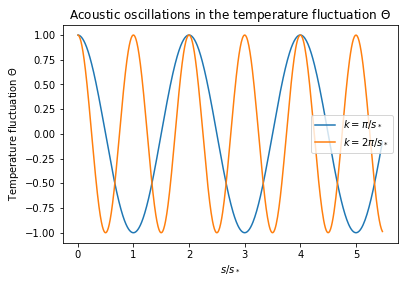

In [5]:
A_s = 2.2 * 10**(-9)
k_st = 0.05  # 1/Mpc
n_s = 0.96
Theta_0 = 1

s_list = np.logspace(np.log(10**(0)), np.log10(1000), 2000)

def Del_z_sq(k):
    """Returns the spectrum of initial curvature perturbations"""
    return A_s * (k/k_st)**(n_s-1)

def Theta(k, s):
    """Returns the temperature fluctuation of modes with wavenumber k and for a sound horizon s"""
    return Theta_0*np.cos(k*s)

Thlist1 = []
Thlist2 = []

for s in s_list:
    k = np.pi/s_st
    Thlist1.append(Theta(k, s))
    k = 2*np.pi/s_st
    Thlist2.append(Theta(k, s))
 
# Plot the Acoustic Oscillations
plt.plot([s/s_st for s in s_list], Thlist1, label='$k=\pi/s_*$')
plt.plot([s/s_st for s in s_list], Thlist2, label='$k=2\pi/s_*$')
plt.xlabel('$s/s_*$')
plt.ylabel('Temperature fluctuation $\Theta$')
plt.title('Acoustic oscillations in the temperature fluctuation $\Theta$')
plt.legend()
plt.savefig('fig2.pdf')
plt.show()

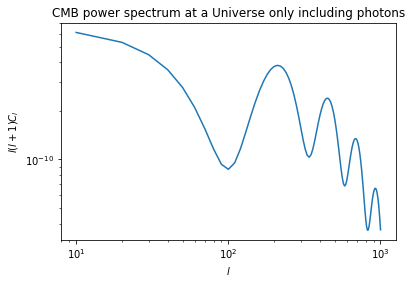

In [6]:
# Characteristic k for implementing silk-damping to the CMB power spectrum
k_D = 0.06  # 1/Mpc

def T(k):
    """Returns the transfer function for a mode with wavenumber k"""
    return Theta(k, s_st)**2

def dC_l_dk(k,l):
    """Returns the integrand for the CMB power spectrum"""
    return 4*np.pi * Del_z_sq(k) * spherical_jn(l, k*D_st)**2 * T(k) * np.exp(-(k/k_D)**2)/ (25*k)

def C_l(l):
    
    i = 10**(-4)
    step = (0.3 - 10**(-4))/1000
    result = 0
    
    while i <= 0.3:
        int_part = lambda l: quad(dC_l_dk, i, i + step, args=(l,))[0]
        result = result + int_part(l)
        i+=step
        
    return result


tab_cl = []

for l in range(10,1001, 10):
    tab_cl.append(C_l(l))
    
llist = np.linspace(10, 1001, 100)

def cl_interp(l):
    return np.interp(l, llist, tab_cl)

def pl_func(func, l):
    return l*(l+1)*func(l)

# Plot the CMB power spectrum
plt.loglog(llist, pl_func(cl_interp, llist))
plt.title('CMB power spectrum at a Universe only including photons')
plt.ylabel('$l(l+1)C_l$')
plt.xlabel('$l$')
plt.savefig('fig3.pdf')
plt.show()

In [7]:
Cl1 = []

for l in llist:
    Cl1.append(pl_func(cl_interp, l))

## CMB of a Universe including photons and baryons

In a Universe which only includes photons the solution to the temperature fluctuations is:

$$
(\Theta + (1+R)\Psi)(k, s)= (\Theta + (1+R)\Psi) _0 \;cos(ks)
$$

where $\Theta _0$ and $\Psi_0$ are the temperature and gravity fluctuation today, respectively.

In the following we, again, choose $\Theta_0 = \Psi _0 = 1$

Finally, s is calculated with a speed of sound $c_s=\frac{c}{\sqrt{3(1+R)}}$

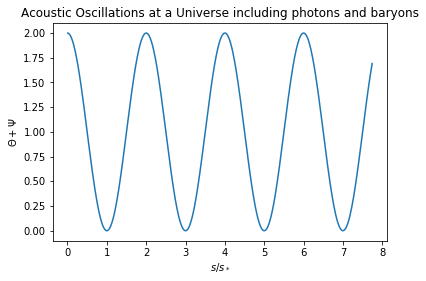

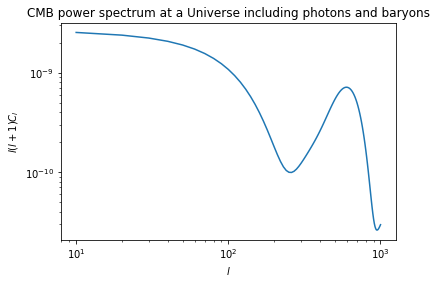

In [8]:
# For a constant baryon-photon momentum ratio R

# Choose the value of R as an independent free parameter
R = 1

# The sound speed in Mpc/s
c_s = c/np.sqrt(3*(1+R))

# The sound horizon at recombination in Mpc
s_st = c_s*quad(dD_dz, a = 1100, b = np.inf)[0]

Psi_0 = 1

def pert(k, s):
    """Returns the total perturbation"""
    return Theta(k, s) + Psi_0

def T(k):
    """Returns the transfer function"""
    return pert(k, s_st)**2

def dC_l_dk(k,l):
    """Returns the integrand for the CMB power spectrum"""
    return 4*np.pi * Del_z_sq(k) * spherical_jn(l, k*D_st)**2 * T(k) * np.exp(-(k/k_D)**2)/ (25*k)

def C_l(l):
    
    i = 10**(-4)
    step = (0.3 - 10**(-4))/1000
    result = 0
    
    while i <= 0.3:
        int_part = lambda l: quad(dC_l_dk, i, i + step, args=(l,))[0]
        result = result + int_part(l)
        i+=step
        
    return result


tab_cl = []

for l in range(10,1001, 10):
    tab_cl.append(C_l(l))
    
llist = np.linspace(10, 1001, 100)

def cl_interp(l):
    return np.interp(l, llist, tab_cl)

def pl_func(func, l):
    return l*(l+1)*func(l)

pert_list = []

for s in s_list:
    k = np.pi/s_st
    pert_list.append(pert(k, s))
   
# Plot the Acoustic Oscillations
plt.plot([s/s_st for s in s_list], pert_list)
plt.title('Acoustic Oscillations at a Universe including photons and baryons')
plt.xlabel('$s/s_*$')
plt.ylabel('$\Theta + \Psi$')
plt.savefig('fig4.pdf')
plt.show()

# Plot the CMB power spectrum
plt.loglog(llist, pl_func(cl_interp, llist))
plt.title('CMB power spectrum at a Universe including photons and baryons')
plt.ylabel('$l(l+1)C_l$')
plt.xlabel('$l$') 
plt.savefig('fig5.pdf')
plt.show()

In [9]:
Cl2 = []

for l in llist:
    Cl2.append(pl_func(cl_interp, l))

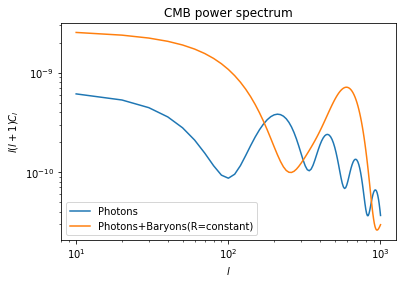

In [10]:
# Plot the CMB power spectrum for a Universe only consisting of photons and for a Universe including both photons and baryons
plt.loglog(llist, Cl1, label = 'Photons')
plt.loglog(llist, Cl2, label = 'Photons+Baryons(R=constant)')
plt.title('CMB power spectrum')
plt.ylabel('$l(l+1)C_l$')
plt.xlabel('$l$')
plt.legend()
plt.savefig('fig6.pdf')
plt.show()

## CMB of a Universe including photons, baryons and dark matter

### Linearized evolution equations

For the complete approach we are going to make use of the following:
$$
x \equiv \frac{\eta}{\eta_r}\;,
$$
and momentum,
$$
\kappa \equiv k \eta_r\;.
$$
Furthermore, we will use the prime, $'$, do denote derivatives w.r.t. the _rescaled conformal time_, for example
$$
a' \equiv \frac{da}{dx}\;.
$$
This notation is different in the lecture notes and script (where it referes just to derivative w.r.t. conformal time), but it simplifies the notation here.

The _rescaled Hubble rate_
$$
\xi \equiv \frac{da/dx}{a} = \frac{a'}{a} = \frac{2\alpha(\alpha x + 1)}{(\alpha x)^2 + 2\alpha x} \equiv \eta_r \mathcal{H}\;,
$$
which is just a function of $x$ (and $\alpha$).


#### Dark Matter

$$
\delta'_c = - \kappa v_c + 3\Phi'
$$
and
$$
v'_c = - \xi  v_c + \kappa \Phi\;. 
$$


#### Photon-Baryon fluid

We have $v_c = v_b$ and $\delta_\gamma = \frac43 \delta_b$ (for adiabatic fluctuations).  
$$
w_x = \frac{1}{3+4R}\;, \quad c^2_{s, X} = \frac{1}{3(1+R)}\;, \quad \delta_X = \frac{3(1+R)}{3+4R} \delta_\gamma\;,
$$
where $R\equiv \frac34\bar\rho_b/\bar\rho_\gamma$.

$$
\delta'_\gamma = -\frac{4}{3} \kappa v_\gamma + 4\Phi' 
$$
and
$$
v'_\gamma = \left(1+\frac{3}{4}y_b\right)^{-1}\left(-\frac{3}{4} y_b \xi v_\gamma + \frac{1}{4} \kappa \delta_\gamma\right) +\kappa\Phi\;.
$$

#### Metric perturbations

$$
\Phi' = -\xi \Phi + \frac{3\xi^2}{2\kappa} \frac{v_\gamma (\frac43 + y - y_c) +v_c y_c}{1+y}\;,
$$
where we defined $y_{c,b} \equiv y (\Omega_{c,b}/\Omega_m)$.


#### Initial conditions

For adiabatic density perturbations, the initial condidtions for the five variables of the five coupled differential equations are given by
$$
\Phi = 1\;,\quad
\delta_\gamma = -2\Phi\;,\quad
\delta_c = \frac34\delta_\gamma\;,\quad
v_\gamma = -\frac14 \frac{\kappa}{\xi} \delta_\gamma\;,\quad
v_c = v_\gamma\;.
$$
By setting $\Phi(x_\text{in})\equiv 1$, we have extracted the amplitude of the primordial curvature perturbation from the transfer function.

In [11]:
# We are going to use the two-fluid approach in order to incorporate dark matter into the model

class Constants(object):
    """Here we simply define a class that contains the constants necessary within the problem."""
    def __init__(self, k=0.001, Om_b = 0.049, Om_c = 0.256, Om_l = 0.695, Om_m = 0.305):
        self.k = k
        self.Om_c = Om_c
        self.Om_b = Om_b
        self.h = 0.675
        self.Om_m = Om_m
        self.Om_l = Om_l
        self.Om_k = -0.8
        self.a_eq = 1/(2.4 * 10**4 * self.Om_m * self.h**2)
        self.H_0 = 217 * 10**(-20) #s^-1
        self.a_rec = 1/1090
        self.eta_r = ((4*self.a_rec)/(self.Om_m*self.H_0**2))**(1/2) * 9.7 * 10**(-15)  # Mpc
        self.a = np.sqrt(self.a_rec/self.a_eq)
        self.kap = self.eta_r * self.k
        self.x_rec = (np.sqrt(self.a**2+1)-1)/self.a
        
class Solver(object):
    """This class will contain some initialisation plus the system of differential equations and the solver"""
    def __init__(self, x, constants):
        self.constants = constants
        self.x = x
        
    def ksi(self, x):
        return 2*self.constants.a*(self.constants.a*x+1)/((self.constants.a*x)**2+2*self.constants.a*x)
    
    def y(self, x):
        return (self.constants.a*x)**2+2*self.constants.a*x
    
    def y_c(self, x):
        return self.y(x)*self.constants.Om_c/self.constants.Om_m
    
    def y_b(self, x):
        return self.y(x)*self.constants.Om_b/self.constants.Om_m

    def dsdx(self, s, x):
        del_c, v_c, phi, del_g, v_g = s
        phi_prime = -self.ksi(x)*phi + ((3*self.ksi(x)**2)/(2*self.constants.kap))*((v_g*(4/3+self.y(x)-self.y_c(x)) + v_c*self.y_c(x))/(1+self.y(x)))
        del_c_prime = -self.constants.kap*v_c + 3*phi_prime
        v_c_prime = -self.ksi(x)*v_c + self.constants.kap*phi
        del_g_prime = -4*self.constants.kap*v_g/3 + 4*phi_prime
        v_g_prime = (1+3*self.y_b(x)/4)**(-1) * (-3*self.y_b(x)*self.ksi(x)*v_g/4 + self.constants.kap*del_g/4) + self.constants.kap*phi
        dsdx = [del_c_prime, v_c_prime, phi_prime, del_g_prime, v_g_prime]
        return dsdx
    
    def solve(self):
        del_c_0 = -1.5
        phi_0 = 1
        del_g_0 = -2
        v_g_0 = -(self.constants.kap/(4*self.ksi(10**(-5))))*del_g_0
        v_c_0 = v_g_0
        s0 = [del_c_0, v_c_0, phi_0, del_g_0, v_g_0]
        sol = odeint(self.dsdx, s0, self.x)
        return sol

### For the Universe as Planck measured it

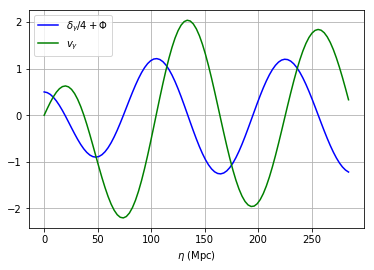

In [12]:
C = Constants(k=0.1)
xlist = np.linspace(10**(-5), C.x_rec, 101)
sol = Solver(xlist, constants = C).solve()
klist = np.logspace(np.log(10**(-4)), np.log10(0.3), 2000)

def func(a, row):
    p = a[:,row]
    return lambda x: np.interp(x, xlist, p)

del_c = func(sol, 0)
phi = func(sol, 2)
del_g = func(sol, 3)
v_g = func(sol, 4)
v_c = func(sol, 1)

plt.plot(xlist*C.eta_r, del_g(xlist)/4 + phi(xlist), 'b', label='$\delta_{\gamma}/4+\Phi$')
plt.plot(xlist*C.eta_r, v_g(xlist), 'g', label='$v_{\gamma}$')
plt.legend(loc='best')
plt.xlabel('$\eta$ (Mpc)')
plt.grid()
plt.savefig('fig7.pdf')
plt.show()

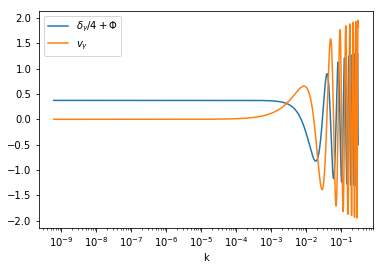

In [13]:
tab_1 = []
tab_2 = []

for item in klist:
    C = Constants(k = item)
    sol = Solver(xlist, constants = C).solve()
    delta = func(sol, 3)
    phi = func(sol, 2)
    v_g = func(sol, 4)
    val_1 = delta(Constants(k = item).x_rec)/4 + phi(Constants(k = item).x_rec)
    val_2 = v_g(Constants(k = item).x_rec)
    tab_1.append(val_1)
    tab_2.append(val_2)
    
def interp_1(k):
    return np.interp(k, klist, tab_1)

def interp_2(k):
    return np.interp(k, klist, tab_2)

plt.semilogx(klist, interp_1(klist), label='$\delta_{\gamma}/4+\Phi$')
plt.semilogx(klist, interp_2(klist), label='$v_{\gamma}$')
plt.legend(loc='best')
plt.xlabel('k')
plt.savefig('fig8.pdf')
plt.show()

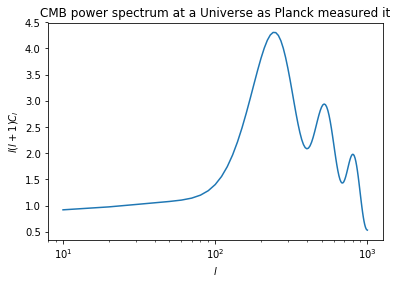

In [14]:
def deta_dz(z):
    
    H = np.sqrt(Constants().H_0**2 * ((1 + z)**3 * Constants().Om_m + Constants().Om_l))
    
    return 1/H

# Conformal time today in s
eta_0 = quad(deta_dz, a = 0, b = float('inf'))[0] * 9.7 * 10**(-15)

# Conformal time at recombination in s
eta_rec = Constants().x_rec*Constants().eta_r

b = eta_0 - eta_rec

def arg(k):
    return k*b

def Del_l(k,l):
    return interp_1(k)*spherical_jn(l, arg(k)) + interp_2(k)*spherical_jn(l, arg(k), derivative = True)

def dC_l_dk(k,l):
    return 4*np.pi*np.exp(-(k/k_D)**2)*Del_l(k,l)**2/k

def C_l(l):
    
    i = 10**(-4)
    step = (0.3 - 10**(-4))/100
    result = 0
    
    while i <= 0.3:
        int_part = lambda l: quad(dC_l_dk, i, i + step, args=(l,))[0]
        result = result + int_part(l)
        i+=step
        
    return result


tab_cl = []
llist = np.linspace(10,1001,100)

for l in range(10,1001,10):
    tab_cl.append(C_l(l))
    
def cl_interp(l):
    return np.interp(l, llist, tab_cl)

def pl_func(func, l):
    return l*(l+1)*func(l)

plt.semilogx(llist, pl_func(cl_interp, llist))
plt.title('CMB power spectrum at a Universe as Planck measured it')
plt.ylabel('$l(l+1)C_l$')
plt.xlabel('$l$')
plt.savefig('fig9.pdf')
plt.show()

In [15]:
Cl3 = []

for l in llist:
    Cl3.append(pl_func(cl_interp, l))

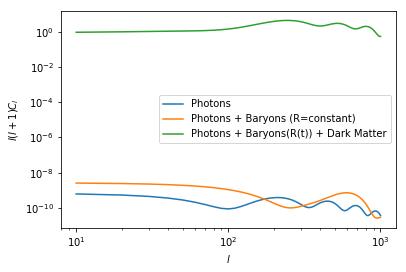

In [16]:
plt.loglog(llist, Cl1, label = 'Photons')
plt.loglog(llist, Cl2, label = 'Photons + Baryons (R=constant)')
plt.loglog(llist, Cl3, label = 'Photons + Baryons(R(t)) + Dark Matter')
plt.ylabel('$l(l+1)C_l$')
plt.xlabel('$l$')
plt.legend()
plt.savefig('fig10.pdf')
plt.show()

### For a Universe only including Cold Dark Matter and no baryons

In [17]:
xlist = np.linspace(10**(-5), Constants(Om_b = 0, Om_c = 0.305).x_rec, 101)

tab_1 = []
tab_2 = []

for item in klist:
    C = Constants(k = item, Om_b = 0, Om_c = 0.305)
    sol = Solver(xlist, constants = C).solve()
    delta = func(sol, 3)
    phi = func(sol, 2)
    v_g = func(sol, 4)
    val_1 = delta(C.x_rec)/4 + phi(C.x_rec)
    val_2 = v_g(C.x_rec)
    tab_1.append(val_1)
    tab_2.append(val_2)
    
def interp_1(k):
    return np.interp(k, klist, tab_1)

def interp_2(k):
    return np.interp(k, klist, tab_2)


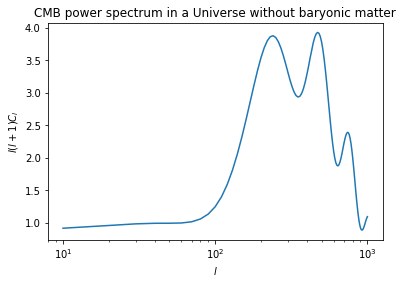

In [18]:
def dC_l_dk(k,l):
    return 4*np.pi*np.exp(-(k/k_D)**2)*Del_l(k,l)**2/k

def C_l(l):
    
    i = 10**(-4)
    step = (0.3 - 10**(-4))/100
    result = 0
    
    while i <= 0.3:
        int_part = lambda l: quad(dC_l_dk, i, i + step, args=(l,))[0]
        result = result + int_part(l)
        i+=step
        
    return result

tab_cl = []

for l in range(10,1001,10):
    tab_cl.append(C_l(l))
    
def cl_interp(l):
    return np.interp(l, llist, tab_cl)

plt.semilogx(llist, pl_func(cl_interp, llist))
plt.title('CMB power spectrum in a Universe without baryonic matter')
plt.ylabel('$l(l+1)C_l$')
plt.xlabel('$l$')
plt.savefig('fig11.pdf')
plt.show()

### For a Universe including only Baryonic matter

In [19]:
xlist = np.linspace(10**(-5), Constants(Om_b = 0.305, Om_c = 0).x_rec, 101)

tab_1 = []
tab_2 = []

for item in klist:
    C = Constants(k = item, Om_b = 0.305, Om_c = 0)
    sol = Solver(xlist, constants = C).solve()
    delta = func(sol, 3)
    phi = func(sol, 2)
    v_g = func(sol, 4)
    val_1 = delta(C.x_rec)/4 + phi(C.x_rec)
    val_2 = v_g(C.x_rec)
    tab_1.append(val_1)
    tab_2.append(val_2)
    
def interp_1(k):
    return np.interp(k, klist, tab_1)

def interp_2(k):
    return np.interp(k, klist, tab_2)


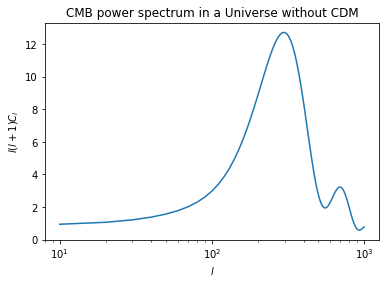

In [20]:
def dC_l_dk(k,l):
    return 4*np.pi*np.exp(-(k/k_D)**2)*Del_l(k,l)**2/k

def C_l(l):
    
    i = 10**(-4)
    step = (0.3 - 10**(-4))/100
    result = 0
    
    while i <= 0.3:
        int_part = lambda l: quad(dC_l_dk, i, i + step, args=(l,))[0]
        result = result + int_part(l)
        i+=step
        
    return result


tab_cl = []

for l in range(10,1001,10):
    tab_cl.append(C_l(l))
    
def cl_interp(l):
    return np.interp(l, llist, tab_cl)

plt.semilogx(llist, pl_func(cl_interp, llist))
plt.title('CMB power spectrum in a Universe without CDM')
plt.ylabel('$l(l+1)C_l$')
plt.xlabel('$l$')
plt.savefig('fig12.pdf')
plt.show()

### For a Universe without a Cosmological Constant

In [21]:
xlist = np.linspace(10**(-5), Constants(Om_b = 0.160, Om_c = 0.893, Om_m = 1, Om_l = 0).x_rec, 101)

tab_1 = []
tab_2 = []

for item in klist:
    C = Constants(k = item, Om_b = 0.160, Om_c = 0.893, Om_m = 1, Om_l = 0)
    sol = Solver(xlist, constants = C).solve()
    delta = func(sol, 3)
    phi = func(sol, 2)
    v_g = func(sol, 4)
    val_1 = delta(C.x_rec)/4 + phi(C.x_rec)
    val_2 = v_g(C.x_rec)
    tab_1.append(val_1)
    tab_2.append(val_2)
    
def interp_1(k):
    return np.interp(k, klist, tab_1)

def interp_2(k):
    return np.interp(k, klist, tab_2)


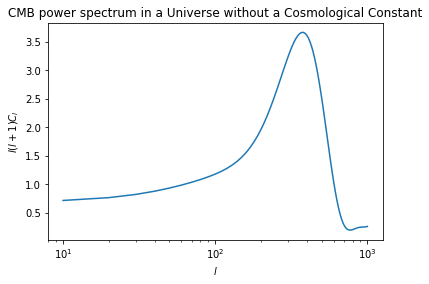

In [22]:
def dC_l_dk(k,l):
    return 4*np.pi*np.exp(-(k/k_D)**2)*Del_l(k,l)**2/k

def C_l(l):
    
    i = 10**(-4)
    step = (0.3 - 10**(-4))/100
    result = 0
    
    while i <= 0.3:
        int_part = lambda l: quad(dC_l_dk, i, i + step, args=(l,))[0]
        result = result + int_part(l)
        i+=step
        
    return result


tab_cl = []

for l in range(10,1001,10):
    tab_cl.append(C_l(l))
    
def cl_interp(l):
    return np.interp(l, llist, tab_cl)

plt.semilogx(llist, pl_func(cl_interp, llist))
plt.title('CMB power spectrum in a Universe without a Cosmological Constant')
plt.ylabel('$l(l+1)C_l$')
plt.xlabel('$l$')
plt.savefig('fig13.pdf')
plt.show()